## Test the hybrid quasiparticle configuration system

Imports

In [1]:
from typing import List
import numpy as np
from scipy.sparse import lil_matrix
from NSMFermions.nuclear_physics_utils import SingleParticleState,get_twobody_nuclearshell_model
from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions import QuasiParticlesConverterOnlynnpp,QuasiParticlesConverter
from scipy.sparse.linalg import eigsh

/home/ecosta/miniconda3/envs/quantum_annealing_nsm/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [122]:
class HybridQuasiParticleConverter():
    
    def __init__(self,):
        pass
    
    def initialize_shell(self,state_encoding:List,fermionic_subset:np.ndarray):
        
        self.fermionic_subset=fermionic_subset
        self.quasiparticle_subset= np.setdiff1d(np.arange(len(state_encoding)), fermionic_subset)
        print(self.quasiparticle_subset)
        #### nn and pp
        couples=[]

        for a,state_a in enumerate(np.array(state_encoding)[self.quasiparticle_subset]):
            for b,state_b in enumerate(np.array(state_encoding)[self.quasiparticle_subset]):
                a_corresponding_index=self.quasiparticle_subset[a]
                b_corresponding_index=self.quasiparticle_subset[b]
                if b_corresponding_index>a_corresponding_index:
                    _,_,ja,ma,_,tza=state_a
                    _,_,jb,mb,_,tzb=state_b
                    if ja==jb and ma==-mb and tza==tzb:
                        couples.append([a_corresponding_index,b_corresponding_index])     

        self.couples=couples



    def new_base_computation(self,base:np.ndarray):
        
        ref_base=base.copy()
        #indices=np.nonzero(base)[0]
        new_base=np.zeros(len(self.couples)+self.fermionic_subset.shape[0])
        value=np.sum(base[self.quasiparticle_subset])
        value2=np.sum(base[self.fermionic_subset])
        
                
        list_of_token_indices=[]
        
        for i in range(len(self.couples)):
            if base[self.couples[i][0]]+base[self.couples[i][1]]!=2 :
                continue
            else:
                new_base[i]+=1
                ref_base[self.couples[i][0]]=0
                ref_base[self.couples[i][1]]=0
        
        new_base[len(self.couples):]=base[self.fermionic_subset]
        if 2*np.sum(new_base[:len(self.couples)]) +np.sum(new_base[len(self.couples):]) == np.sum(base):
            return new_base
        
    def get_the_basis_matrix_transformation(self,basis:np.ndarray):
        
        self.quasiparticle_basis=[]
        self.rest_basis=[]
        
        for i,b in enumerate(basis):
            qp_base=self.new_base_computation(base=b.copy())
            
            if qp_base is not(None):

                self.quasiparticle_basis.append(qp_base)
            else:
                self.rest_basis.append(b.copy())
        self.quasiparticle_basis=np.asarray(self.quasiparticle_basis)
        
        self.rest_basis=np.asarray(self.rest_basis)
        
        self.particles2quasiparticles=lil_matrix((self.quasiparticle_basis.shape[0],basis.shape[0]))
        self.particles2restofstates=lil_matrix((self.rest_basis.shape[0],basis.shape[0]))
        qp_idx=0
        rest_idx=0
        for i,b in enumerate(basis):
            qp_base=self.new_base_computation(base=b.copy())
            
            if qp_base is not(None):
                self.particles2quasiparticles[qp_idx,i]=1.
                qp_idx+=1
            else:
                self.particles2restofstates[rest_idx,i]=1
                rest_idx+=1
                


Load the encoding

In [190]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

HQPC=HybridQuasiParticleConverter()

index=np.array( [0,1,2,3,4,5])
index2=np.array([6,7,8,9,10,11])+12

fermion_subset=np.concatenate((index,index2)) 
print(fermion_subset)
HQPC.initialize_shell(state_encoding=SPS.state_encoding,fermionic_subset=fermion_subset)
print(HQPC.couples)
QPC=QuasiParticlesConverterOnlynnpp()
QPC.initialize_shell(state_encoding=SPS.state_encoding)

QPCnp=QuasiParticlesConverter()
QPCnp.initialize_shell(state_encoding=SPS.state_encoding)

[ 0  1  2  3  4  5 18 19 20 21 22 23]
[ 6  7  8  9 10 11 12 13 14 15 16 17]
[[np.int64(6), np.int64(7)], [np.int64(8), np.int64(11)], [np.int64(9), np.int64(10)], [np.int64(12), np.int64(17)], [np.int64(13), np.int64(16)], [np.int64(14), np.int64(15)]]


#### Test using the basis of the NSM Hamiltonian

In [183]:
size=len(SPS.energies)//2
nparticles_a=4
nparticles_b=10

In [125]:
twobody_matrix,_=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


In [191]:
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size,size_b=size,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
NSMHamiltonian.get_external_potential(SPS.energies)
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
NSMHamiltonian.get_hamiltonian()

egs,psigs=NSMHamiltonian.get_spectrum(n_states=1)
print(egs)



Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:02<00:00, 6199.51it/s]


✅ Two-body operator built: shape=(4206, 4206), nnz=579704
[-145.69199725]


In [2]:
HQPC.get_the_basis_matrix_transformation(NSMHamiltonian.basis.copy())

QPC.get_the_basis_matrix_transformation(NSMHamiltonian.basis.copy())

QPCnp.get_the_basis_matrix_transformation(NSMHamiltonian.basis.copy())
print(HQPC.quasiparticle_basis.shape,QPC.quasiparticle_basis.shape,QPCnp.quasiparticle_basis.shape)


NameError: name 'HQPC' is not defined

In [193]:
print(HQPC.particles2quasiparticles.shape)
print(HQPC.quasiparticle_basis.shape)

(200, 4206)
(200, 18)


In [ ]:
for i,b in enumerate(NSMHamiltonian.basis):
    for j,d in enumerate(HQPC.quasiparticle_basis):
        if HQPC.particles2quasiparticles[j,i]!=0.:
            print('basis=',np.nonzero(b)[0],b)
            print('quasiparticle=',np.nonzero(d)[0])    
            print(HQPC.new_base_computation(b))
            print('quasiparticle base=',QPC.new_base_computation(b))
            print(HQPC.particles2quasiparticles[j,i],'\n')


In [1]:
hamiltonian_HQ=HQPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ HQPC.particles2quasiparticles.T
egsHQ,psi_HQ=eigsh(hamiltonian_HQ,k=1,which='SA')
print(QPC.quasiparticle_basis.shape)
hamiltonian_Q=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
egsQ,psi_Q=eigsh(hamiltonian_Q,k=1,which='SA')

hamiltonian_Qnp=QPCnp.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPCnp.particles2quasiparticles.T
egsQnp,psi_Qnp=eigsh(hamiltonian_Qnp,k=1,which='SA')

print(egsQ,egsHQ,egsQnp)

psi_HQ2particle=HQPC.particles2quasiparticles.T @ psi_HQ[:,0]
psi_HQ2particle/=np.linalg.norm(psi_HQ2particle)

psi_Q2particle=QPC.particles2quasiparticles.T @ psi_Q[:,0]
psi_Q2particle/=np.linalg.norm(psi_Q2particle)

psi_Qnp2particle=QPCnp.particles2quasiparticles.T @ psi_Qnp[:,0]
psi_Qnp2particle/=np.linalg.norm(psi_Qnp2particle)

print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))

print(psigs[:,0].dot(psi_HQ2particle.conj())*np.conjugate(psigs[:,0].dot(psi_HQ2particle.conj())))


print(psigs[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Qnp2particle.conj())))


NameError: name 'HQPC' is not defined

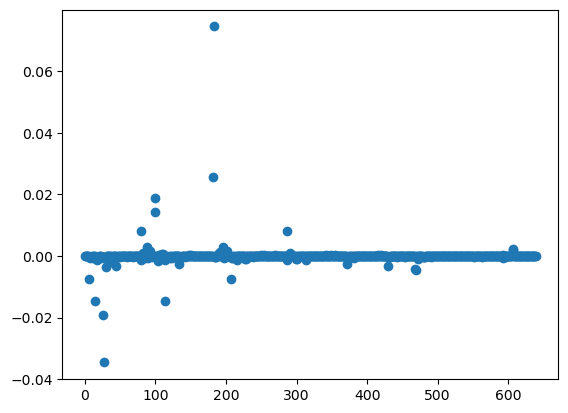

In [182]:
import matplotlib.pyplot as plt

#plt.bar(np.arange(psigs.shape[0])+0.5,psi_Q2particle*psi_Q2particle.conj())
plt.scatter(np.arange(psigs.shape[0]),psi_HQ2particle*psi_HQ2particle.conj()-psigs[:,0]*psigs[:,0].conj())
plt.show()

#### Search of the best set of fermionic DOF

In [235]:
couples=[]

#### Trace out proton degrees of freedom 

In [176]:
rho_Q2particle=NSMHamiltonian.reduced_state(indices=index,psi=psi_Q2particle)
rho_gs=NSMHamiltonian.reduced_state(indices=index,psi=psigs)
print(rho_Q2particle.shape,rho_gs.shape)


# basis for the reduced state

combinations = product([0, 1], repeat=len(index))
# Convert each combination into a numpy array
basis = np.asarray([np.array(combination) for combination in combinations])

(16, 16) (16, 16)


In [178]:
print(np.linalg.trace(rho_Q2particle))

0.9999999999999999


0.6051154448562251


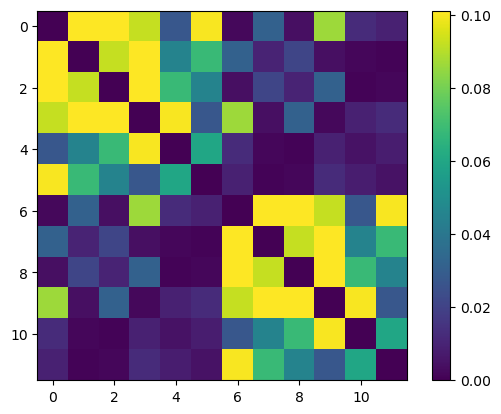

In [180]:
print(fidelity(rho_gs,rho_Q2particle))

mi_gs=NSMHamiltonian.mutual_info(psi=psigs)

plt.imshow(mi_gs)
plt.colorbar()
plt.show()

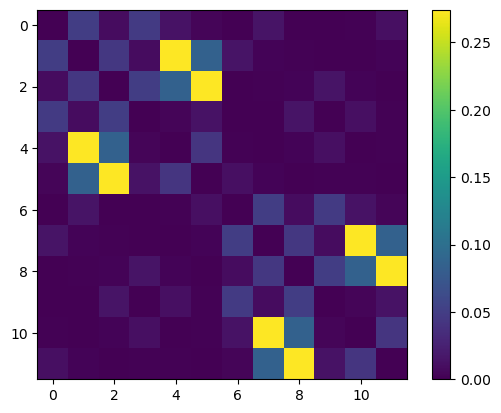

In [182]:
mi_Q=NSMHamiltonian.mutual_info(psi=psi_HQ2particle)

plt.imshow(mi_Q)
plt.colorbar()
plt.show()